In [1]:
import cobra
from cobra.io.mat import *
import warnings
warnings.simplefilter('ignore')
#from cobra.sampling import sample
from cobra.sampling import OptGPSampler, ACHRSampler
import os
cpus = os.cpu_count()
from cobra.io.json import load_json_model
model = load_matlab_model("./COBRA_models/GEM_Recon2_thermocurated_redHUMAN.mat")
print(
model.optimize(),
cpus)

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
This model seems to have metHMDB instead of metHMDBID field. Will use metHMDB for what metHMDBID represents.
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, x


<Solution 3.198 at 0x7f79c6947d00> 20


In [11]:
model.metabolites.get_by_id('gdp_e')

Metabolite identifier,gdp_e
Name,GDP
Memory address,0x7f79c5344100
Formula,C10H13N5O11P2
Compartment,e
In 3 reaction(s),"NTP3e, NDP3ex, EX_gdp_e"


In [2]:

#from acevedo_clss_and_fcns import * 
#model                                 = load_json_model("./COBRA_models/GEM_Recon2_thermocurated_redHUMAN.json")

#print("init sampler")
import re
from itertools import compress



rxns        = [ r.id for r in model.reactions]
subsystems  = [s.subsystem for s in model.reactions]
subsys_bool = [bool(re.search("Phen|phen|Tetrahydrobiopterin", s)) for s in subsystems]
subsys_rxns = list(compress(rxns, subsys_bool))

reversible = [
'PHETA1',
'PHETA1m',
'r0547',
'RE0830C',
'RE0830N',
'RE1709C',
'RE1709N',
'RE2660C',
'RE2660N']

forward_rxns =  list(set(subsys_rxns)-set(reversible))

for r in forward_rxns:
    model.reactions.get_by_id(r).bounds  = (1e-8, 10)
    
    
for r in reversible:
    model.reactions.get_by_id(r).bounds  = (-10, 10)

print(model.optimize())  



<Solution 3.198 at 0x7f79c6947d00>


In [3]:
model.reactions.get_by_id('PHETA1').bounds  = (-10, 10)
model.reactions.get_by_id('PHETA1m').bounds  = (-10, 10)




co    = model.problem.Constraint(model.reactions.biomass.flux_expression,
                                 lb=.01 * model.optimize().objective_value,
                                 ub=.99 * model.optimize().objective_value)
model.add_cons_vars([co])


print(model.optimize())  

<Solution 3.166 at 0x7f79ddfdc700>


In [4]:

optgp = OptGPSampler(model, processes=cpus, thinning=1000)

In [5]:
samples = optgp.sample(10_000)
samples[reversible]

,PHETA1,PHETA1m,r0547,RE0830C,RE0830N,RE1709C,RE1709N,RE2660C,RE2660N
0,0.0,0.0,-0.000846,0.453055,0.453039,-0.453055,-0.453039,-0.453055,-0.453039
1,0.0,0.0,-0.001099,0.451590,0.451769,-0.451590,-0.451769,-0.451590,-0.451769
2,0.0,0.0,-0.000917,0.449268,0.449458,-0.449268,-0.449458,-0.449268,-0.449458
3,0.0,0.0,-0.000975,0.447948,0.448138,-0.447948,-0.448138,-0.447948,-0.448138
4,0.0,0.0,-0.155405,0.133686,0.133876,-0.133686,-0.133876,-0.133686,-0.133876
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,-0.239111,3.419600,2.976940,-3.419600,-2.976940,-3.419600,-2.976940
9996,0.0,0.0,-0.144444,3.509212,3.066725,-3.509212,-3.066725,-3.509212,-3.066725
9997,0.0,0.0,-0.128994,3.389089,2.944080,-3.389089,-2.944080,-3.389089,-2.944080
9998,0.0,0.0,-0.193905,3.470381,3.025088,-3.470381,-3.025088,-3.470381,-3.025088


In [9]:


samples.to_parquet("./results/data/flux_samples/flux_samples_v2_10_000.parquet.gzip", compression='gzip')  

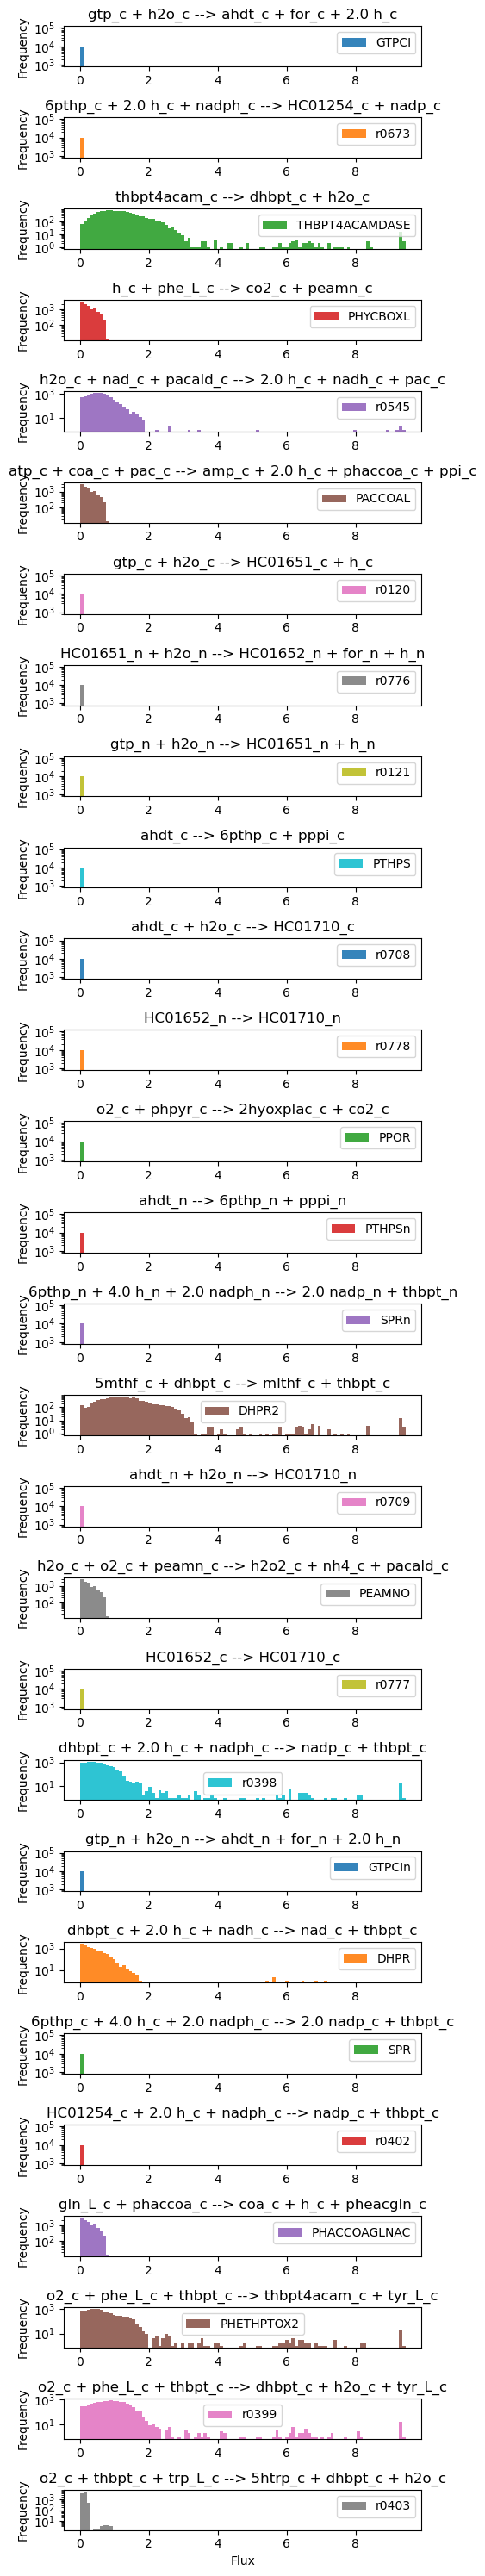

In [8]:
import matplotlib.pyplot as plt

#rxn_list = ['biomass', 'r0399', 'PHETHPTOX2', 'r0403', 'DHPR', 'DHPR2', 'r0398']

rxn_list = forward_rxns
formulas =  [model.reactions.get_by_id(r).reaction if r != 'biomass' else 'biomass' for r in rxn_list]


#fig, axes = plt.subplots(nrows=4, ncols=4)

samples[rxn_list].plot.hist(bins=100, alpha=0.9, figsize=(5,30), subplots=True, sharey=False, 
                      sharex=False, logy = True, title = formulas, ylabel = ['', '', ''], grid=False)
plt.xlabel('Flux') 
#plt.ylabel(None)
#plt.ylabel("common Y")
#fig.supylabel('common y label')
plt.tight_layout()
plt.show()

# ---------------------END------------------------------------

In [2]:






def sample_fluxes(model,file_path,n_samples, Sampler, if_pku: bool=False):
        if if_pku:
            bounds_blocked   = (0, 0)
            model.reactions.get_by_id('r0399').bounds = bounds_blocked
        else:
            bounds_unblocked = (0, 100)
            model.reactions.get_by_id('r0399').bounds = bounds_unblocked

        model.reactions.get_by_id('PHETHPTOX2').bounds = (0, 0)
        model.reactions.get_by_id('r0403').bounds = (0, 100)
        model.reactions.get_by_id('DHPR').bounds  = (0, 100)
        model.reactions.get_by_id('DHPR2').bounds  = (0, 100)
        model.reactions.get_by_id('r0398').bounds  = (0, 100)

        samples = Sampler.sample(n_samples)
        samples.to_parquet(file_path, compression='gzip')  
    

#sample_fluxes(model, "./results/data/flux_samples/flux_samples_CONTROL.parquet.gzip",
#              False, 10,  Sampler = optgp)
sample_fluxes(model, "./results/data/flux_samples/flux_samples_v2.parquet.gzip",
              n_samples = 10,  Sampler = optgp)

KeyboardInterrupt: 

In [ ]:
#flux_samples_CONTROL    = pd.read_parquet( "./results/data/flux_samples/flux_samples_CONTROL.parquet.gzip")
flux_samples_PKU        = pd.read_parquet( "./results/data/flux_samples/flux_samples_PKU.parquet.gzip")




In [3]:

rxn_list = ['biomass', 'r0399', 'PHETHPTOX2', 'r0403', 'DHPR', 'DHPR2', 'r0398']


formulas =  [model.reactions.get_by_id(r).reaction if r != 'biomass' else 'biomass' for r in rxn_list]
import matplotlib.pyplot as plt


#fig, axes = plt.subplots(nrows=4, ncols=4)
s[rxn_list].plot.hist(bins=100, alpha=0.9, figsize=(5,10), subplots=True, sharey=False, 
                      sharex=False, logy = True, title = formulas, ylabel = ['', '', ''], grid=False)
plt.xlabel('Flux') 
#plt.ylabel(None)
#plt.ylabel("common Y")
#fig.supylabel('common y label')
plt.tight_layout()
plt.show()

In [89]:
from cobra.io import save_json_model
assert model.genes.__len__() > 0
s.to_parquet("results/data/flux_samples.parquet.gzip", compression='gzip')
save_json_model(model, "models/GEM_Recon2_thermocurated_redHUMAN.json")